# Práctica 2: Reutilización de grandes modelos neuronales

En la segunda práctica del módulo vamos a utilizar la técnica más extendida para el uso productivo de redes neuronales: la **reutilización**, aka, **transfer learning**. Usaremos esta tecnica para dar solución al problema el cual hemos enfrentado en la práctica 1 sin mucho éxito. El dataset que vamos a utilizar es el mismo que en la Practica 1, que se puede encontrar [aquí](https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset).

La parte final de esta práctica tiene como objetivo enfrentar de principio a fin un caso de uso utilizando Redes Neuronales Convolucionales reutilizadas.

La practica tiene **dos ejercicios**:

1. Ej 1. Aprender a reutilizar modelos (5 puntos)
2. Ej 2. Problema de clasificación end-to-end (5 pts)

### Objetivos

Los objetivos esta primera práctica son los siguientes:
- Reutilización de modelos y su adaptación a problemas concretos.
- Utilización de técnicas de *data augmentation* utilizando PyTorch.
- Utilización de modelos y pesos pre-entrenados de PyTorch.
- Enfrentar un problema de reutilización desde el principio hasta el final.




### Consideraciones generales en el uso de Notebooks
- Asegúrate de que todo el código necesario para ejecutarlo completamente está disponible.
- Asegúrate de usar un orden lógico de ejecución de celdas para permitir una ejecución completa y automática. El Notebook debe poder funcionar perfectamente simplemente lanzando la opción "Restart & Run All" de la sección "Kernel". Cuidado con instanciar variables o métodos en celdas posteriores a las cuales están utilizadas, una ejecución independiente y manual puede hacer que funcione, pero la ejecución automática fallará.
- Asegúrate de utilizar las celdas de tipo "Markdown" para texto y las de "Code" para código. Combinar distintos tipos de celda ayuda a la explicabilidad de la resolución y a la limpieza en general.
- Puedes crear celdas adicionales si lo necesitas.
- A la hora de la entrega del Notebook definitivo, asegúrate que lo entregas ejecutado y con las salidas de las celdas guardadas. Esto será necesario para la generación del PDF de entrega.
- El código cuanto más comentado mejor. Además, cualquier reflexión adicional siempre será bienvenida.

## Ej 1. Aprender a reutilizar modelos (5 puntos)

El objetivo de la práctica de esta semana será utilizar otra estrategia enfrentar el problema que venimos arrastrando de la primera actividad: la clasificación de emociones en imágenes de animales.

Como pudiste observar, diseñar una red neuronal convencional y adaptar los datos para su uso resultó en un rendimiento muy pobre: no logró aprender y sus predicciones se daban practicamente al  azar. Posteriormente, utilizamos una arquitectura convencional, concretamente una AlexNet, para intentar mejorar el rendimiento. El resultado, de nuevo, dejó mucho que desear.

No sé si te has parado a analizar el problema que estamos enfrentando. ¿Has visto las fotos de los animales? ¿Sabrías decir si los pájaros están tristes, contentos...? En definitiva, es un problema complicado de resolver. Además, como recordarás de la teoría, las redes neuronales exigen muchos datos para ser entrenadas, más aún si hay que enfrentar un problema complejo como este. ¿Cuál es la realidad?, que únicamente contamos con 1000 imágenes para entrenar... ya hemos visto que no son suficientes para entrenar redes neuronales.

Llegados a este punto, existen dos opciones que pueden ser perfectamente complementarias:
1.  **Obtener más datos**. El problema es que no siempre es sencillo (ni barato). Para lograr obtener más datos la solución alternativa pasa por utilizar técnicas de *data augmentation*. Por ejemplo, se pueden utilizar modelos generativos (desde GANs hasta modelos de difusion como DALLE-2), o utilizar modelos de Style Transfer para generar variantes estilísticas de una misma imagen. Una alternativa muy comun y facil de implementar para *data augmentation* consiste en realizar **transformaciones a las imagenes**. Con más datos, podremos nutrir nuestro conjunto de entrenamiento y, casi con total seguridad, mejoraremos el rendimiento de nuestras redes. El problema es, ¿cuántos datos son suficientes? La respuesta: muchos. Y más aún si queremos entrenar una red desde 0.

2.  **Utilizar Transfer Learning**. Podemos reutilizar tanto la arquitectura como los pesos de un modelo entrenado con buenas métricas para adaptarlo a nuestro problema en concreto y, con eso, solventar parcialmente la falta de datos.

En esta practica vamos a desarrollar **la segunda opción**, ya que suele ser la más viable en problemas "reales". Ademas, si queremos aplicar data augmentation usando transformaciones, necesitaremos entrenar el modelo mas epochs. Esto es porque PyTorch cambia el contenido de cada imagen en cada época, no aumenta el
tamaño del dataset directamente. Dejo como **ejercicio voluntario** el intentar aumentar el conjunto de datos para mejorar aún más el rendimiento de alguno de los modelos, teniendo en cuenta que habra que entrenar durante mas epochs.




### Importar las librerias necesarias


In [1]:
import torch, torchvision
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### Ej 1.1: Carga de datos y modelo (0.5 puntos)

Los datos que vamos a utilizar serán los mismos que en la Práctica 1, que los tienes disponibles [aqui](https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset). Como opción alternativa a la descarga en local, se pueden tambien cargar en cache como se ofreció en la Practica 1:


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Carlos\.cache\kagglehub\datasets\anshtanwar\pets-facial-expression-dataset\versions\11



La diferencia reside en que en la Práctica 1, las transformaciones aplicadas sobre las imágenes en bruto (variable *transformations*) era diseñada por nosotros. En este caso, dado que vamos a utilizar un modelo pre-entrenado, habrá que adaptarse al formato de dato que espera el modelo para unos pesos en concreto. Dependiendo del diseño de la fuente de donde se carguen los modelos, las transformaciones se pueden obtener de distinta forma.

En este caso, vamos a hacer uso de los modelos que Torchvision ofrece de forma nativa, que tenéis disponibles [aqui](https://pytorch.org/vision/stable/models.html). Concretamente, vamos a utilizar:

- Un modelo **Efficient Net B1**.
- Como pesos, la segunda versión (v2) de los entrenados sobre IMAGENET1K.

En el caso de Torchvision, las transformaciones se pueden localizar en el atributo *transforms* de los pesos. Para recuperar el pipeline completo de pre-procesamiento, se puede hacer uso de `weights.transforms()`.

In [4]:
# Importar los pesos específicos de EfficientNet B1 v2
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

weights = EfficientNet_B1_Weights.IMAGENET1K_V2 # Completar
model = efficientnet_b1(weights=weights) # Completar
transformation = weights.transforms()

model = model.to(device)

print(f"Modelo cargado: EfficientNet B1 - v2")
print(f"Pesos utilizados: {weights}")
print(f"Transformaciones obtenidas automáticamente:\n\n {transformation}\n")

Modelo cargado: EfficientNet B1 - v2
Pesos utilizados: EfficientNet_B1_Weights.IMAGENET1K_V2
Transformaciones obtenidas automáticamente:

 ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)



In [5]:
# No incluido en la práctic 2
# Listado de los directorios del dtaset

import os

dataset_base = r"C:\Users\Carlos\.cache\kagglehub\datasets\anshtanwar\pets-facial-expression-dataset\versions\11"

for item in os.listdir(dataset_base):
   item_path = os.path.join(dataset_base, item)
   if os.path.isdir(item_path):
       print(f"=> {item}/")
       # Ver subdirectorios
       for sub_item in os.listdir(item_path):
           sub_path = os.path.join(item_path, sub_item)
           if os.path.isdir(sub_path):
               print(f"     => {sub_item}/")

=> Angry/
=> happy/
=> Master Folder/
     => test/
     => train/
     => valid/
=> Other/
=> Sad/


Ya podemos entonces crear las instancias de **Dataset** para los tres conjuntos: `train_dataset`, `validation_dataset` y `test_dataset`. ¡No olvides aplicar las transformaciones recuperadas anteriormente!

In [6]:
# Path de kagglehub para la ubicación de los datos.
data_path = r"C:\Users\Carlos\.cache\kagglehub\datasets\anshtanwar\pets-facial-expression-dataset\versions\11\Master Folder"

# Crear los datasets con las transformaciones del modelo pre-entrenado
train_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, 'train'),
    transform=transformation
)
validation_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, 'valid'),
    transform=transformation
)
test_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, 'test'),
    transform=transformation
)

print(f"Dataset de entrenamiento: {len(train_dataset)} imágenes.")
print(f"Dataset de validación: {len(validation_dataset)} imágenes.")
print(f"Dataset de test: {len(test_dataset)} imágenes.")
print(f"El dataset contiene '{len(train_dataset.classes)}' clases  > >> {train_dataset.classes} ")
# print(f"Numero de clases: {len(train_dataset.classes)}")

Dataset de entrenamiento: 1000 imágenes.
Dataset de validación: 36 imágenes.
Dataset de test: 38 imágenes.
El dataset contiene '4' clases  > >> ['Angry', 'Other', 'Sad', 'happy'] 


Creamos los **DataLoader** correspondientes a cada **Dataset**: `train_dataloader`, `validation_dataloader` y `test_dataloader`. Utilizaremos para todos ellos `batch_size` de 64, con el objetivo de agilizar el entrenamiento, y mezcla en los datos.

In [7]:
from torch.utils.data import DataLoader

In [8]:

# Configurar parámetros de carga
batch_size = 64  # Tamaño de batch 
num_workers = 4  # Núcleos de CPU para cargar datos en paralelo

# Crear los DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,        # Mezclar datos de entrenamiento
    num_workers=num_workers,
    pin_memory=True      # Optimización para GPU
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,       # No mezclar validación (orden no importa)
    num_workers=num_workers,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,       # No mezclar test
    num_workers=num_workers,
    pin_memory=True
)

print(f"DataLoaders creados:")
print(f"- Train: {len(train_dataloader)} batches de {batch_size}")
print(f"- Validation: {len(validation_dataloader)} batches de {batch_size}")
print(f"- Test: {len(test_dataloader)} batches de {batch_size}")

DataLoaders creados:
- Train: 16 batches de 64
- Validation: 1 batches de 64
- Test: 1 batches de 64


### Ej 1.2: Adaptación del modelo (2 puntos)

Los pesos que hemos seleccionado han sido entrenados utilizando IMAGENET en su versión con 1000 etiquetas. Nuestro problema es diferente, por lo que tendremos que adaptar el modelo.

El objetivo será "congelar" toda la parte convolucional del modelo, es decir, el extractor de características. Congelar implica que los parámetros no se entrenen, por dos motivos:
- No queremos "ensuciar" el entrenamiento que se ha realizado.
- No tenemos recursos suficientes para entrenar una red con este número de parámetros.

Posteriormente, modificaremos el clasificador para adaptar el modelo a nuestro problema.

Muestra la arquitectura del modelo cargado:

In [9]:
# Mostrar la arquitectura del modelo cargado
print("Arquitectura completa del modelo EfficientNet B1:")
print(model)
print("\n" + "==="*20)
print(f"Número total de parámetros: {sum(p.numel() for p in model.parameters()):,}")



Arquitectura completa del modelo EfficientNet B1:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigm

### Comentario de la casilla anterior

En la casilla anterior se lista la arquitectura del algoritmo EfficientNet B1, el cual tiene tres secciones principales:
1. (features)   =   es el extractor de características. Son todas las capas convolucionales que extraen patrones como bordes, formas, texturas, objetos...
2. (avgpool)    =   el Pooling promedio. Ayduda a reducir el tamaño. Convierte los mapas de características a vector.
3. (classifier) =   Se trata del clasificador y es la parte final del proceso que usa una red clasica o Red Densa (Fully Connected Network). Contiene 2 capas: Dropout + Linear. REduce las clases a las 4 clases finales y toma la decisión de a que clase pertenecen los datos que le van llegando (las 4 emociones).

Congela los parámetros de toda la red, es decir, configura los parámetros para que no requieran el cómputo del gradiente.

In [10]:
# Congelar todos los parámetros del extractor de características. Itera sobre todos los parámetros de la sección "features" con model.features.parameters()
for param in model.features.parameters():
    param.requires_grad = False

# Verificar cuántos parámetros están congelados vs entrenables
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros congelados: {frozen_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Parámetros totales: 7,794,184
Parámetros congelados: 6,513,184
Parámetros entrenables: 1,281,000


### Comentario de la casilla anterior

El bucle for itera por cada uno de los parámetros de la sección features del model y los congela con "param.requires_grad = False".

El siguiente bloque verifica cuantos elementos hay en el modelo con la funciond de Pytorch .numel() y los divide en totales y los que estan congelados. Por último, la resta de estos dos valores nos da el total de parametros entrenables, que en realidad es el paso donde el clasifier reduce la clasificación a 1000 clases, que hace lo siguiente: 1000 + bias nos da = 1.281.000 parametros entrenables (si lo he entendido bien)

Localiza la capas o capas que actúan como clasificadores. ¿Cuántas son? ¿Cómo se llama el bloque que las contiene?

In [11]:
# mostrar los bloques principales del modelo
print(" BLOQUES PRINCIPALES ")
print("¨" * 60)
bloques = list(model.named_children())
for i, (name, _) in enumerate(bloques):
    print(f"  {i+1}. {name}")

print("¨" * 60)
# Obtener  los nombres de las capas dentro del clasificador
print(f" Capas dentro del bloque 'classifier':")
capas_clasificador = [type(capa).__name__ for capa in model.classifier]
for i, capa in enumerate(capas_clasificador):
    print(f"  {i+1}. {capa}")
    
# print(f"Capas dentro del bloque 'classifier': {capas_clasificador}")

print("¨" * 60)
print(f" El bloque clasificador se llama: {bloques[2][0]}")
print(f" Contiene {len(model.classifier)} capas: {', '.join(capas_clasificador)}")
print("¨" * 60)


# print(f"• Contiene {len(model.classifier)} capas: {', '.join(capas_clasificador)}")

 BLOQUES PRINCIPALES 
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨
  1. features
  2. avgpool
  3. classifier
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨
 Capas dentro del bloque 'classifier':
  1. Dropout
  2. Linear
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨
 El bloque clasificador se llama: classifier
 Contiene 2 capas: Dropout, Linear
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨


## Comentario de la casilla anterior

### En el código anterior hay 3 partes:

La primera lista los bloques principales que contiene el modelo. 

La segunda muestra las capas dentro del modelo clasificador. 

La tercera es simplemente una respuesta resumida de lo anterior.


.

.

Define un nuevo clasificador adaptado a nuestro problema:
*   Una capa de Dropout con probabilidad de **0.3** y que realice la operación **inplace**.
*   Una capa Linear adecuada: hay que definir el número de *features* de entrada y el número de *features* de salida.


In [12]:
in_features = model.classifier[1].in_features
num_classes = len(train_dataset.classes)

new_head = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features, num_classes)
)

# Transferir el nuevo clasificador a CUDA ANTES de asignarlo
new_head = new_head.to(device)
model.classifier = new_head

model = model.to(device)
print(f"✅ Modelo completo transferido a: {device}")
print(f"✅ Clasificador en: {next(model.classifier.parameters()).device}")


✅ Modelo completo transferido a: cuda
✅ Clasificador en: cuda:0


Actualiza el clasificador del modelo. Por defecto, el nuevo clasificador no tendrá los pesos congelados y, por tanto, se entrenará.

In [13]:
# Actualizar el clasificador del modelo
model.classifier = new_head



Muestra y verifica que el modelo está actualizado con la nueva arquitectura:

In [14]:
# Verificar que se ha actualizado correctamente
print("^" * 60)
print("   CLASIFICADOR ACTUALIZADO ")
print("^" * 60)

print(f"Nuevo clasificador:")
print(model.classifier)
print("¨" * 60)

print(f"\nDimensiones de la capa Linear:")
print(f"Entrada: {model.classifier[1].in_features}")
print(f"Salida: {model.classifier[1].out_features}")
print("¨" * 60)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
   CLASIFICADOR ACTUALIZADO 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Nuevo clasificador:
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨

Dimensiones de la capa Linear:
Entrada: 1280
Salida: 4
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨


### Comentario del código anterior



<table>
<tr>

<td width="50%" style="padding: 20px; vertical-align: top;">


Con anterioridad a este paso, obtuvimos que:
    
(0): Dropout(p=0.2, inplace=True)

(1): Linear(in_features=1280, out_features=1000, bias=True)



</td>

<td width="50%" style="padding: 20px; vertical-align: top;">

Después de actualizar de clasificador tenemos:
  
(0): Dropout(p=0.3, inplace=True)
  
(1): Linear(in_features=1280, out_features=4, bias=True)

</td>
</tr>
</table>



### Ej 1.3: Checkpoints (1.5 puntos)

Ya tenemos todo listo para poder entrenar nuestro modelo. El único problema es que el entrenamiento va a ser costoso (aunque podría serlo muchísimo más), por lo que lo correcto es utilizar *checkpoints* para evitar cualquier inconveniente que pueda ocurrir durante el entrenamiento que haga que el entrenamiento se detenga y, por tanto, echar a perder todo el cómputo realizado.

Es por ello que antes que nada vamos a crear dos funciones que permitan guardar y cargar un *checkpoint* utilizando las herramientas que nos proporciona PyTorch. Recuerda guardar todo lo que sea necesario para que el modelo pueda ser recuperado íntegramente o, al menos, que pueda seguir entrenando por donde iba.

En PyTorch, el formato para guardar *checkpoints* es *.pth*.

#### Método para guardar un *checkpoint*
- **path**: Dirección donde se va a almacenar el *checkpoint*
- **model**: Instancia del modelo a almacenar
- **optimizer**: Optimizador utilizado, con el objetivo de guardar su estado (recuerda que hay optimizadores con hiperparámetros progresivos).

El método no devuelve nada.

In [15]:
def save_checkpoint(path, model, optimizer):
    
    if not path.endswith(".pth"):
        print("El checkpoint debe tener formato .pth")
        return
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    
    torch.save(checkpoint, path)
    print(f"Checkpoint guardado en: {path}")

#### Método para recuperar un *checkpoint*
- **path**: Dirección donde se va a recuperar el *checkpoint*
- **model**: Instancia "vacía" del modelo recuperado. La arquitectura debe ser la misma que a la hora del guardado.
- **optimizer**: Instancia nueva del optimizador recuperado. Debe ser del mismo tipo para poder actualizar su estado.

El método debe devolver:
- **model**: Modelo actualizado.
- **optimizer**: Optimizador actualizado.

In [16]:
def load_checkpoint(path, model, optimizer):
    if not path.endswith(".pth"):
        print("El checkpoint debe tener formato .pth")
        return
    
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"Checkpoint cargado desde: {path}")
    return model, optimizer

### Ej 1.4: Entrenamiento del modelo (1.0 punto)

Finalmente, ya tenemos toda la información y herramientas necesarias para proceder a entrenar el modelo. A continuacion, se ofrecen los metodos para entrenar y evaluar los conjuntos de validation/test que ya se trabajaron en la Practica 1.

In [17]:
def training(dataloader, model, loss_fn, optimizer):

    model.train() # Indicamos al modelo que vamos a entrenar

    num_batches = len(dataloader) # Número de batches para promediar el loss
    size = len(dataloader.dataset)

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader): # Iteramos por los distintos batches creados en el dataloader

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X) # Calculamos el forward pass
        loss = loss_fn(pred, y) # Calculamos el loss

        _,predicted=torch.max(pred,1)
        correct+=(y==predicted).sum().item()

        # Backpropagation
        optimizer.zero_grad() # Limpiamos los gradientes viejos
        loss.backward() # Calculamos los nuevos gradientes
        optimizer.step() # Actualizamos los parámetros (pesos) del modelo

        train_loss += loss.item()

    correct /= size
    avg_train_loss = train_loss/num_batches
    accuracy = 100*correct
    print(f"Train Metrics: \n Accuracy: {accuracy:>0.1f}%, Avg train loss: {avg_train_loss:>8f}\n")
    return avg_train_loss, accuracy

In [18]:
def test_and_validation(dataloader, model, loss_fn):

    model.eval() # Indicamos que no vamos a entrenar

    test_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _,predicted=torch.max(pred,1)
            correct+=(y==predicted).sum().item()

    test_loss /= num_batches
    correct /= size

    avg_loss = test_loss
    accuracy = 100*correct
    print(f"Val or Test Metrics: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return avg_loss, accuracy

Utilizaremos **Adam** como optimizador y **CrossEntropyLoss** como función de coste:

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters())

Entrena durante **4 épocas** el modelo guardando al final de cada una de ellas un *checkpoint*. Puedes reescribir siempre el mismo o crear un *checkpoint* para cada una de las épocas.

**Atención**: Para simplemente probar el código te recomiendo que pruebes únicamente con una época.

In [20]:
# verificando que el "device" es --->> cuda
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"Device actual: {device}")
print(f"Modelo en device: {next(model.parameters()).device}")

CUDA disponible: True
Device actual: cuda
Modelo en device: cuda:0


In [27]:
epochs = 4
for t in range(epochs):
    print(f"\n-------------------------------\n  ==> Epoch - {t+1}\n-------------------------------\n")
    
    # Entrenar
    training(train_dataloader, model, loss_fn, optimizer)
    
    # Validar
    test_and_validation(validation_dataloader, model, loss_fn)
    
    # Guardar checkpoint al final de cada época
    save_checkpoint(f"checkpoint_epoch_{t+1}.pth", model, optimizer)
    
    print(f"\n-------------------------------\n")


-------------------------------
  ==> Epoch - 1
-------------------------------

Train Metrics: 
 Accuracy: 69.1%, Avg train loss: 0.934270

Val or Test Metrics: 
 Accuracy: 50.0%, Avg loss: 1.236083 

Checkpoint guardado en: checkpoint_epoch_1.pth

-------------------------------


-------------------------------
  ==> Epoch - 2
-------------------------------

Train Metrics: 
 Accuracy: 70.5%, Avg train loss: 0.913130

Val or Test Metrics: 
 Accuracy: 52.8%, Avg loss: 1.234703 

Checkpoint guardado en: checkpoint_epoch_2.pth

-------------------------------


-------------------------------
  ==> Epoch - 3
-------------------------------

Train Metrics: 
 Accuracy: 71.8%, Avg train loss: 0.889898

Val or Test Metrics: 
 Accuracy: 50.0%, Avg loss: 1.235596 

Checkpoint guardado en: checkpoint_epoch_3.pth

-------------------------------


-------------------------------
  ==> Epoch - 4
-------------------------------

Train Metrics: 
 Accuracy: 73.3%, Avg train loss: 0.868803

Val or

## Comentario de la casilla anterior
Tras repetidas ejecuciones, 5 ciclos consecutivos del entrenamiento han dado estos outputs:


<table> <tr> <td>  **Train Accuracy**  
  
**Ejecución 1**: 36.5% → 72.1%  
**Ejecución 2**: 72.8% → 76.3%   
**Ejecución 3**: 76.3% → 77.8%  
**Ejecución 4**: 80.2% → 78.5%  
**Ejecución 5**: 79.5% → 83.6%  


</td> <td> **Validation Accuracy**  
  
**Ejecución 1**: 41.7% → 52.8%  
**Ejecución 2**: 52.8% → 52.8%  
**Ejecución 3**: 52.8% → 52.8%  
**Ejecución 4**: 52.8% → 50.0%  
**Ejecución 5**: 52.8% → 50.0%  

</td> <td> **Validation Loss**  
  
**Ejecución 1**: 1.309 → 1.243  
**Ejecución 2**: 1.227 → 1.226  
**Ejecución 3**: 1.227 → 1.236  
**Ejecución 4**: 1.246 → 1.243  
**Ejecución 5**: 1.255 → 1.274  

</td> </tr> </table>

<table> <tr> 

"mensaje después de terminar el ejercicio 1.4."

 Al final del ejercicio 1.4 y después de escribir todos los comentarios de todas las casillas.
- he reiniciado el kernel y por lo tanto el resultado del training despues de reiniar no cuadra no cuadra con la última ejecución de la primera tabla 😂😂.. 

añado los valores obtenidos despues de reiniciar el kernel </tr>

<tr><td>  **Train Accuracy**  

Época 1: 69.1%  
Época 2: 70.5%  
Época 3: 71.8%  
Época 4: 73.3%  
</td><td> **Validation Accuracy**  

Época 1: 50.0%  
Época 2: 52.8%  
Época 3: 50.0%  
Época 4: 50.0%  
</td><td> **Validation Loss**  

Época 1: 1.236  
Época 2: 1.235  
Época 3: 1.236  
Época 4: 1.239  
</td></tr></table>

Observaciones:
  
<table>
<tr>
<td>

- **Train Accuracy**: Obtiene una mejora progresiva de más del 70%
- **Validation Accuracy**: Muestra un estancamiento sobre ~50-53%
- **Validation Loss**: Se mantiene estable ~1.23-1.27

</td>
</tr>

<tr>
<td>

El estancamiento del `Validation` nos da a entender que hay `OverFitting`. Un resultado óptimo sería cuando: 


- El Accuracy de `Training` y `Validation` tuviera en ambos una subida progresiva y mantuviera un "gap" del 10-15% o menos de diferencia.
- El `Loss` de Train y Validation tuviera en ambos una bajada progresiva.

</td>
</tr>

</table>





Ahora, vamos a utilizar los **checkpoints** para entrenar el modelo mas epochs.

Carga el último **checkpoint** generado en la útima época del último entrenamiento en las nuevas variables `model_recovered` y `optimizer_recovered` para entrenar el modelo **4 épocas más**.

Consideraciones:
- El loss en test de la última época del primer entrenamiento **debe coincidir** con el loss en test antes de la primera época del segundo entrenamiento. Muestra ambos valores para verificar que, efectivamente, estás entrenando el "mismo" modelo.
- Para cargar un *checkpoint* la arquitectura del modelo debe ser la misma que a la hora de guardarlo. Si mantienes la misma sesion de colab y tienes el modelo **Efficient Net B1** correctamnte adaptado y en la variable `model`, puedes usar esta variable para cargar el checkpoint. Si este no es el caso, deberás crear una instancia nueva del Efficient Net y repetir el proceso seguido en el ejercicio 1.2 para adaptar su arquitectura y, con ello, poder cargar los pesos.

In [30]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
# Cargar el último checkpoint en nuevas variables
print("¨" * 60 + "\n")
model_recovered = model  # Reutilizar modelo existente (misma sesión)

# Crear optimizador IGUAL al original (solo classifier.parameters)
optimizer_recovered = torch.optim.Adam(model_recovered.classifier.parameters(), lr=0.001)

# Cargar el último checkpoint
checkpoint = load_checkpoint("checkpoint_epoch_4.pth", model_recovered, optimizer_recovered)

print("¨" * 60 + "\n")

print("Evaluando modelo cargado ANTES del segundo entrenamiento:")
print()
test_and_validation(validation_dataloader, model_recovered, loss_fn)
print("¨" * 60 + "\n")


¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨



C:\Users\Carlos\AppData\Local\Temp\ipykernel_39620\3128740935.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Checkpoint cargado desde: checkpoint_epoch_4.pth
¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨

Evaluando modelo cargado ANTES del segundo entrenamiento:

Val or Test Metrics: 
 Accuracy: 50.0%, Avg loss: 1.238840 

¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨



## Comentario de la casilla anterior

`Loss` = 1.238840  ->  ambos coinciden (época 4 del entrenamiento anterior y checkpoit cargado)

Ahora podemos proceder con el re-entrenamiento con el modelo recien cargado usando el checkpoint. Implementa el codigo para entrenar **4 epochs mas** el modelo en la variable `model_recovered`

In [31]:
epochs = 4
for t in range(epochs):
    print(f"\n-------------------------------\n  ==> Epoch - {t+1}\n-------------------------------\n")
    
        # Entrenar
    training(train_dataloader, model_recovered, loss_fn, optimizer_recovered)
    
    # Validar
    test_and_validation(validation_dataloader, model_recovered, loss_fn)
    
    # Guardar checkpoint con nomenclatura diferente
    save_checkpoint(f"checkpoint_recovered_epoch_{t+1}.pth", model_recovered, optimizer_recovered)
    
    print(f"\n-------------------------------\n")


-------------------------------
  ==> Epoch - 1
-------------------------------

Train Metrics: 
 Accuracy: 74.0%, Avg train loss: 0.839671

Val or Test Metrics: 
 Accuracy: 50.0%, Avg loss: 1.241052 

Checkpoint guardado en: checkpoint_recovered_epoch_1.pth

-------------------------------


-------------------------------
  ==> Epoch - 2
-------------------------------

Train Metrics: 
 Accuracy: 75.6%, Avg train loss: 0.823094

Val or Test Metrics: 
 Accuracy: 50.0%, Avg loss: 1.243219 

Checkpoint guardado en: checkpoint_recovered_epoch_2.pth

-------------------------------


-------------------------------
  ==> Epoch - 3
-------------------------------

Train Metrics: 
 Accuracy: 75.0%, Avg train loss: 0.818892

Val or Test Metrics: 
 Accuracy: 50.0%, Avg loss: 1.241706 

Checkpoint guardado en: checkpoint_recovered_epoch_3.pth

-------------------------------


-------------------------------
  ==> Epoch - 4
-------------------------------

Train Metrics: 
 Accuracy: 76.2%, Av

**Responde a las siguientes preguntas:**
1. ¿Mejora este modelo una clasificación al azar?

2. ¿Sufre el modelo de Overfitting o Underfitting?

3. ¿Crees que podría seguir mejorando sus métricas? ¿Cómo?

Puedes hacer uso (optativo) de la funcion `plot_comparative` de la Practica 1 para visualizar el `accuracy` con respecto a las epochs de entrenamiento. Para ello deberas guardar en una lista el `accuracy` durante el entrenamiento.  

### Respuesta


<table>
<tr>

<td width="100%" style="padding: 20px; vertical-align: top;">

1. No hay mejoría significativa, la mejora es mínima. 

2. El modelo sufre de OverFitting severo. El gap entre el `Train` y el `Val` sigue siendo muy grande, más del 30%. 
El cambio del `Loss` es también marginal. El `Val Accuracy` no mejora. El modelo ha memorizado el dataset y no generaliza.

3. Con el enfoque actual, entrenando el modelo más epocas incrementaría el `OverFitting`.

</td>
</tr>
<tr>

<td width="100%" style="padding: 20px; vertical-align: top;">

 Después de esta segunda fase de entrenamiento -> en realidad el checkpoint sería como aplicar una pausa   
 y esta segunda fase de la casilla anterior, sería simplemente como quitarle el pausado. Se trata del mismo
 entrenamiento y sigue teniendo los mismos síntomas.

</td>

</tr>
</table>


In [32]:
# Datos extraídos de los outputs del entrenamiento (8 épocas totales)
train_accuracies = [79.5, 81.8, 82.4, 83.6, 82.2, 83.0, 82.4, 83.4]
validation_accuracies = [52.8, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
epochs_list = list(range(1, 9))  # Épocas 1-8

print("Datos del entrenamiento:")
print(f"Épocas: {epochs_list}")
print(f"Train Accuracy: {train_accuracies}")
print(f"Validation Accuracy: {validation_accuracies}")

Datos del entrenamiento:
Épocas: [1, 2, 3, 4, 5, 6, 7, 8]
Train Accuracy: [79.5, 81.8, 82.4, 83.6, 82.2, 83.0, 82.4, 83.4]
Validation Accuracy: [52.8, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]


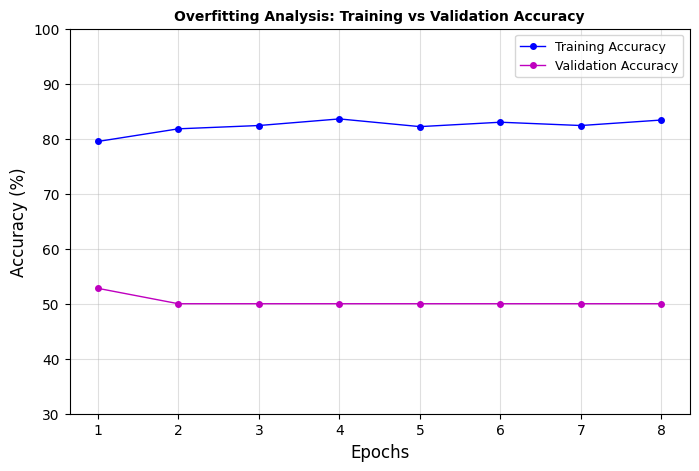

In [33]:
import matplotlib.pyplot as plt

def plot_comparative(epochs, train_acc, val_acc, title="Training vs Validation Accuracy"):
    plt.figure(figsize=(8, 5))
    
    # Plotear ambas curvas
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy', linewidth=1, markersize=4)
    plt.plot(epochs, val_acc, 'm-o', label='Validation Accuracy', linewidth=1, markersize=4)
    
    # Configuración del gráfico
    plt.title(title, fontsize=10, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.4)
    plt.ylim(30, 100)  # Rango (y) apropiado para nuestros datos
        
    # plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_comparative(epochs_list, train_accuracies, validation_accuracies, 
                "Overfitting Analysis: Training vs Validation Accuracy")

## Comentario

Como ya comenté anteriormente, reinicié muy alegremetne el kernel después de haber terminado todas las ejecuciones y haber escrito todos comentarios con las tablas, etc. Todavía me estoy arripin tiendo, jaja 😂. Bueno, tuve que hacer algunos cambios mínimos en mis comentarios y añadir alguna cosilla más. Espero que esté todo correcto y cuando corrijas esperes encontrar la lógica esperada.

## Ej 2. Problema de clasificación end-to-end (5 pts)

En esta última semana se va a poner en práctica todos los conocimientos adquiridos a lo largo de este módulo: deberás desarrollar un modelo neuronal para la clasificación de imágenes de frutas que ofrezca el mayor *accuracy* posible. No hay más indicaciones o limitaciones que las siguientes:
- El dataset a utilizar será el siguiente: [https://www.kaggle.com/datasets/sshikamaru/fruit-recognition/data](https://www.kaggle.com/datasets/sshikamaru/fruit-recognition/data).
- Has de reutilizar un modelo neuronal utilizando PyTorch, tú decides el grado de reutilización. Ideas:
  - Modelos de PyTorch Hub. [https://pytorch.org/hub/](https://pytorch.org/hub/)
  - Modelos de Torchvision. [https://pytorch.org/vision/0.13/models.html](https://pytorch.org/vision/0.13/models.html)

Trata de explicar todos los pasos seguidos y las decisiones de diseño. Recuerda, a modo de guía, los pasos habituales:

1. Adquisición de datos y carga en **Datasets**. Recomiendo aqui hacer un **EDA** para conocer bien la naturaleza del dataset.
2. Creación de **DataLoaders**.
3. Adaptación del modelo pre-entrenado.
4. Definición de optimizador y función de coste apropiadas.
5. Entrenamiento y validación.
6. Análisis de métricas en test (las visualizaciones son bienvenidas)

¡A por ello!

In [34]:
# Importar librerías básicas
import torch
import torchvision
from torchvision import datasets, transforms
import os

# Verificar si tenemos GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponible: {device}")

Dispositivo disponible: cuda
